# I. Load Packages

In [1]:
!pip install sentence_transformers
!pip install pytorch-tabular pytorch-lightning


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from pytorch_tabnet.tab_model import TabNetClassifier
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from warnings import simplefilter
from xgboost import XGBClassifier

# II. Data Preprocessing

In [3]:
# drive.mount('/content/drive', force_remount=True)
# dataset_path = '/content/drive/MyDrive/BT4012/twitter_human_bots_dataset.csv' #change your directory to this
dataset_path = './twitter_human_bots_dataset.csv'

In [4]:
dataset = pd.read_csv(dataset_path)

In [5]:
dataset.head()

,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


In [6]:
dataset.info() # general observation about data. preview of first 5 rows. no completely null rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    37438 non-null  int64  
 1   created_at                    37438 non-null  object 
 2   default_profile               37438 non-null  bool   
 3   default_profile_image         37438 non-null  bool   
 4   description                   30181 non-null  object 
 5   favourites_count              37438 non-null  int64  
 6   followers_count               37438 non-null  int64  
 7   friends_count                 37438 non-null  int64  
 8   geo_enabled                   37438 non-null  bool   
 9   id                            37438 non-null  int64  
 10  lang                          29481 non-null  object 
 11  location                      37434 non-null  object 
 12  profile_background_image_url  32939 non-null  object 
 13  p

In [7]:
print(dataset.isnull().sum())
print(dataset.shape)

Unnamed: 0                         0
created_at                         0
default_profile                    0
default_profile_image              0
description                     7257
favourites_count                   0
followers_count                    0
friends_count                      0
geo_enabled                        0
id                                 0
lang                            7957
location                           4
profile_background_image_url    4499
profile_image_url                  1
screen_name                        0
statuses_count                     0
verified                           0
average_tweets_per_day             0
account_age_days                   0
account_type                       0
dtype: int64
(37438, 20)


In [8]:
dataset['description'].fillna('No description', inplace=True)
dataset['profile_background_image_url'].fillna('No Image', inplace=True)
dataset['profile_image_url'].fillna('No Image', inplace=True)
dataset['lang'].fillna('unknown', inplace=True)
dataset['location'].fillna('unknown', inplace=True)

dataset['location'] = dataset['location'].str.lower()
dataset['location'] = dataset['location'].str.replace(r'[^a-z\s]', '', regex=True)
dataset['location'] = dataset['location'].str.strip()

dataset['description'] = dataset['description'].str.lower()
dataset['description'] = dataset['description'].str.replace(r'[^a-z\s]', '', regex=True)
dataset['description'] = dataset['description'].str.strip()

print(dataset.isnull().sum())

Unnamed: 0                      0
created_at                      0
default_profile                 0
default_profile_image           0
description                     0
favourites_count                0
followers_count                 0
friends_count                   0
geo_enabled                     0
id                              0
lang                            0
location                        0
profile_background_image_url    0
profile_image_url               0
screen_name                     0
statuses_count                  0
verified                        0
average_tweets_per_day          0
account_age_days                0
account_type                    0
dtype: int64


In [9]:
dataset['profile_background_image_url'] = dataset['profile_background_image_url'].apply(lambda x: 0 if x == 'No Image' else 1)
dataset['profile_image_url'] = dataset['profile_image_url'].apply(lambda x: 0 if x == 'No Image' else 1)
dataset.rename(columns={'account_type': 'bot'}, inplace=True)
dataset['bot'] = dataset['bot'].apply(lambda x: 1 if x == 'bot' else 0)
dataset['verified'] = dataset['verified'].astype(int)
dataset['geo_enabled'] = dataset['geo_enabled'].astype(int)
dataset['default_profile'] = dataset['default_profile'].astype(int)
dataset['default_profile_image'] = dataset['default_profile_image'].astype(int)
dataset['created_at'] = pd.to_datetime(dataset['created_at'])
dataset['hour_created'] = dataset['created_at'].dt.hour

dataset.head()

,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,...,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,bot,hour_created
0,0,2016-10-15 21:32:11,0,0,blame xaiax inspired by makinginvisible using ...,4,1589,4,0,787405734442958848,...,unknown,1,1,best_in_dumbest,11041,0,7.870,1403,1,21
1,1,2016-11-09 05:01:30,0,0,photographing the american west since i speci...,536,860,880,0,796216118331310080,...,estados unidos,1,1,CJRubinPhoto,252,0,0.183,1379,0,5
2,2,2017-06-17 05:34:27,0,0,scruffy looking nerf herder and twitch broadca...,3307,172,594,1,875949740503859204,...,los angeles ca,1,1,SVGEGENT,1001,0,0.864,1159,0,5
3,3,2016-07-21 13:32:25,1,0,wifegodmotherfriendfeline fanatic assistant pr...,8433,517,633,1,756119643622735875,...,birmingham al,0,1,TinkerVHELPK5,1324,0,0.889,1489,0,13
4,4,2012-01-15 16:32:35,0,0,loan coach at mancity aspiring dj,88,753678,116,1,464781334,...,england united kingdom,1,1,JoleonLescott,4202,1,1.339,3138,0,16


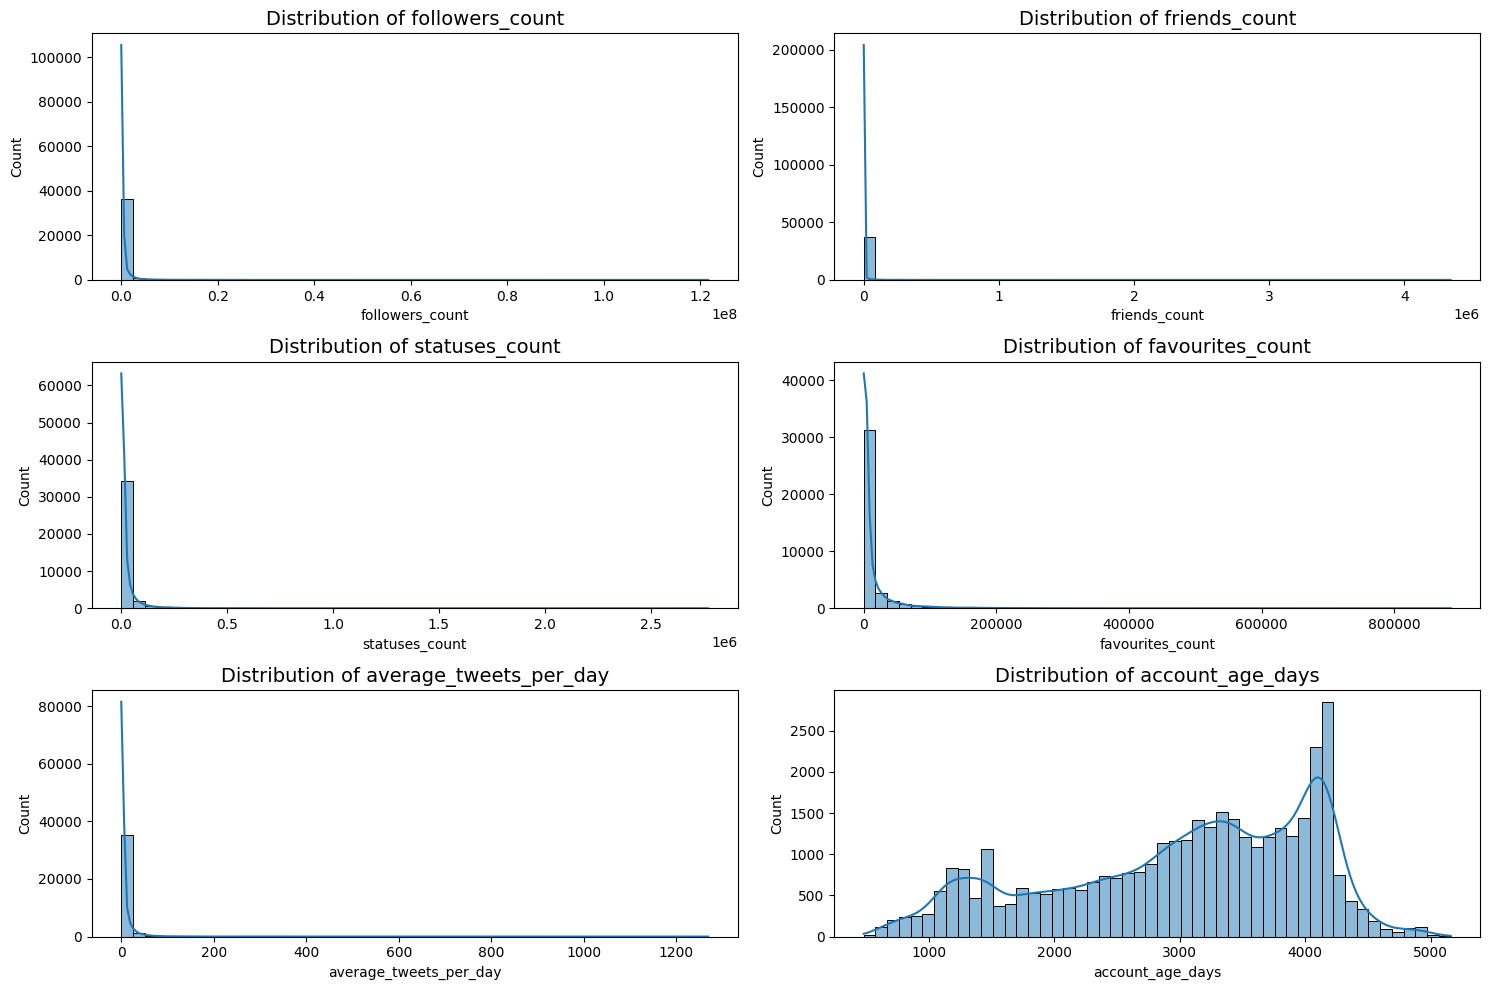

In [10]:
# List of numerical columns
numerical_columns = ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'average_tweets_per_day', 'account_age_days']

# Plot the distribution of each numerical variable
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(dataset[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}', fontsize=14)

plt.tight_layout()
plt.show()

### Data Transformation due to skewed distribution

In [11]:
# Calculate average daily followers
dataset['average_daily_followers'] = dataset['followers_count'] / dataset['account_age_days']

# Calculate average daily favorites (favourites_count)
dataset['average_daily_favs'] = dataset['favourites_count'] / dataset['account_age_days']

# Calculate average daily friends (friends_count)
dataset['average_daily_friends'] = dataset['friends_count'] / dataset['account_age_days']

# Display the dataset with the new columns
print(dataset[['average_daily_followers', 'average_daily_favs', 'average_daily_friends']].head())

   average_daily_followers  average_daily_favs  average_daily_friends
0                 1.132573            0.002851               0.002851
1                 0.623640            0.388687               0.638144
2                 0.148404            2.853322               0.512511
3                 0.347213            5.663533               0.425118
4               240.177820            0.028043               0.036966


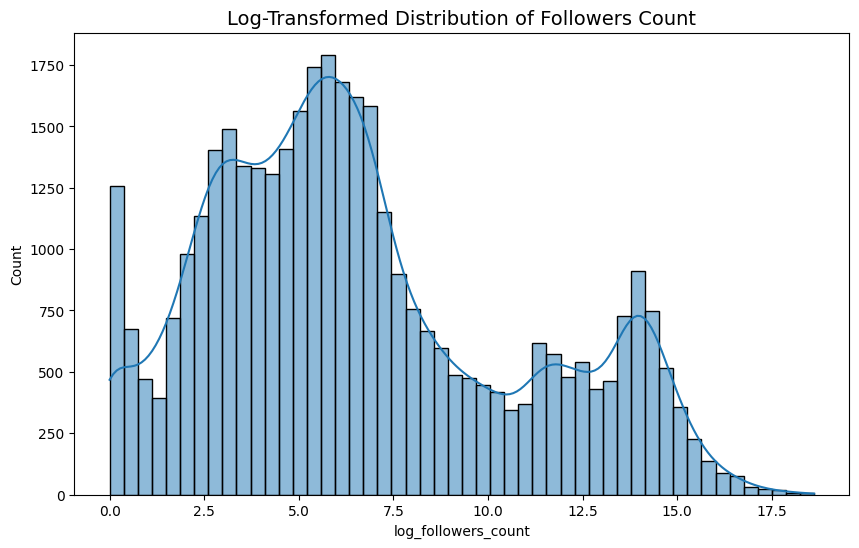

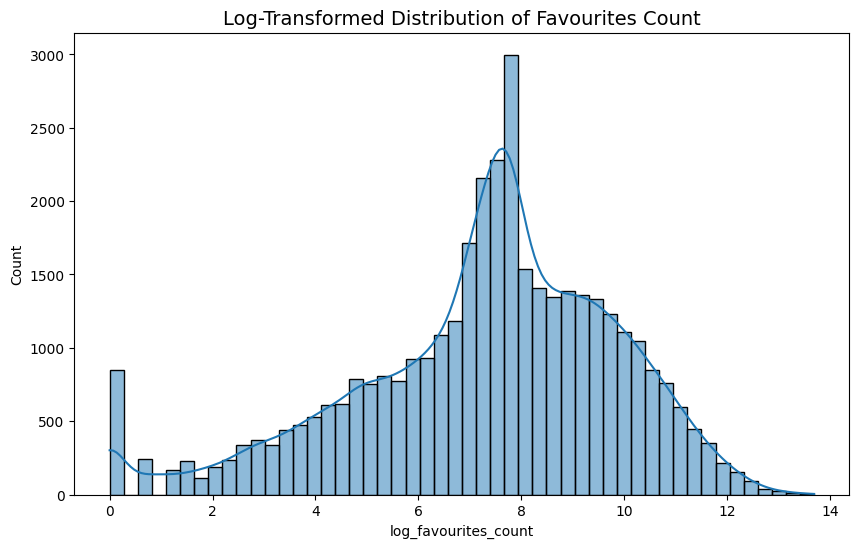

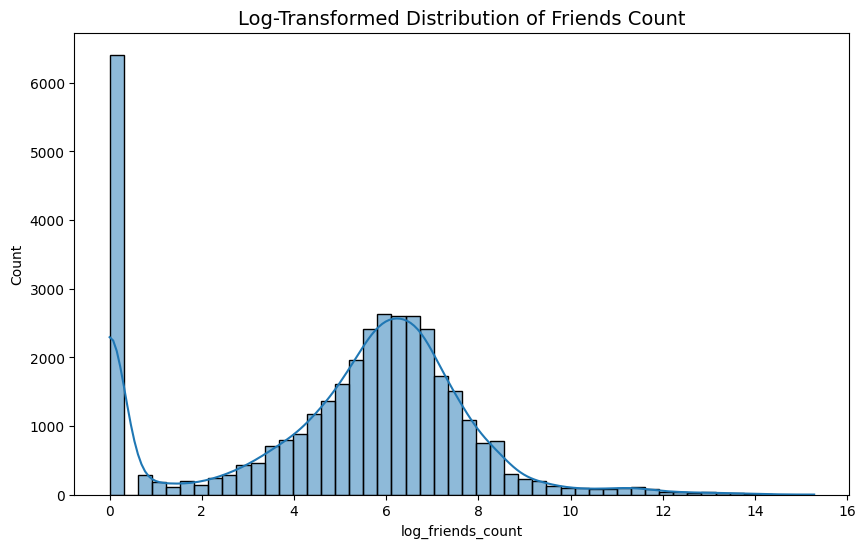

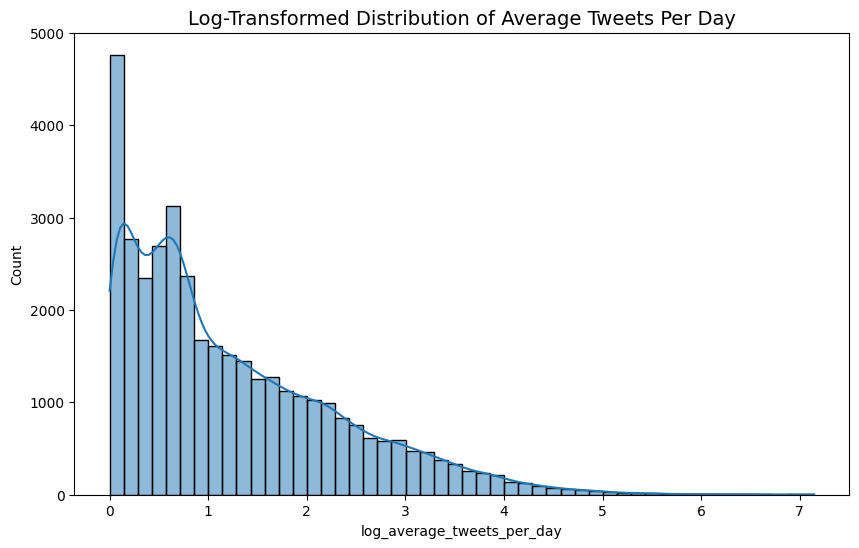

In [12]:
# Apply log transformation (add 1 to avoid log(0))
dataset['log_followers_count'] = np.log1p(dataset['followers_count'])
plt.figure(figsize=(10, 6))
sns.histplot(dataset['log_followers_count'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of Followers Count', fontsize=14)
plt.show()

dataset['log_favourites_count'] = np.log1p(dataset['favourites_count'])
plt.figure(figsize=(10, 6))
sns.histplot(dataset['log_favourites_count'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of Favourites Count', fontsize=14)
plt.show()

dataset['log_friends_count'] = np.log1p(dataset['friends_count'])
plt.figure(figsize=(10, 6))
sns.histplot(dataset['log_friends_count'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of Friends Count', fontsize=14)
plt.show()

dataset['log_average_tweets_per_day'] = np.log1p(dataset['average_tweets_per_day'])
plt.figure(figsize=(10, 6))
sns.histplot(dataset['log_average_tweets_per_day'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of Average Tweets Per Day', fontsize=14)
plt.show()

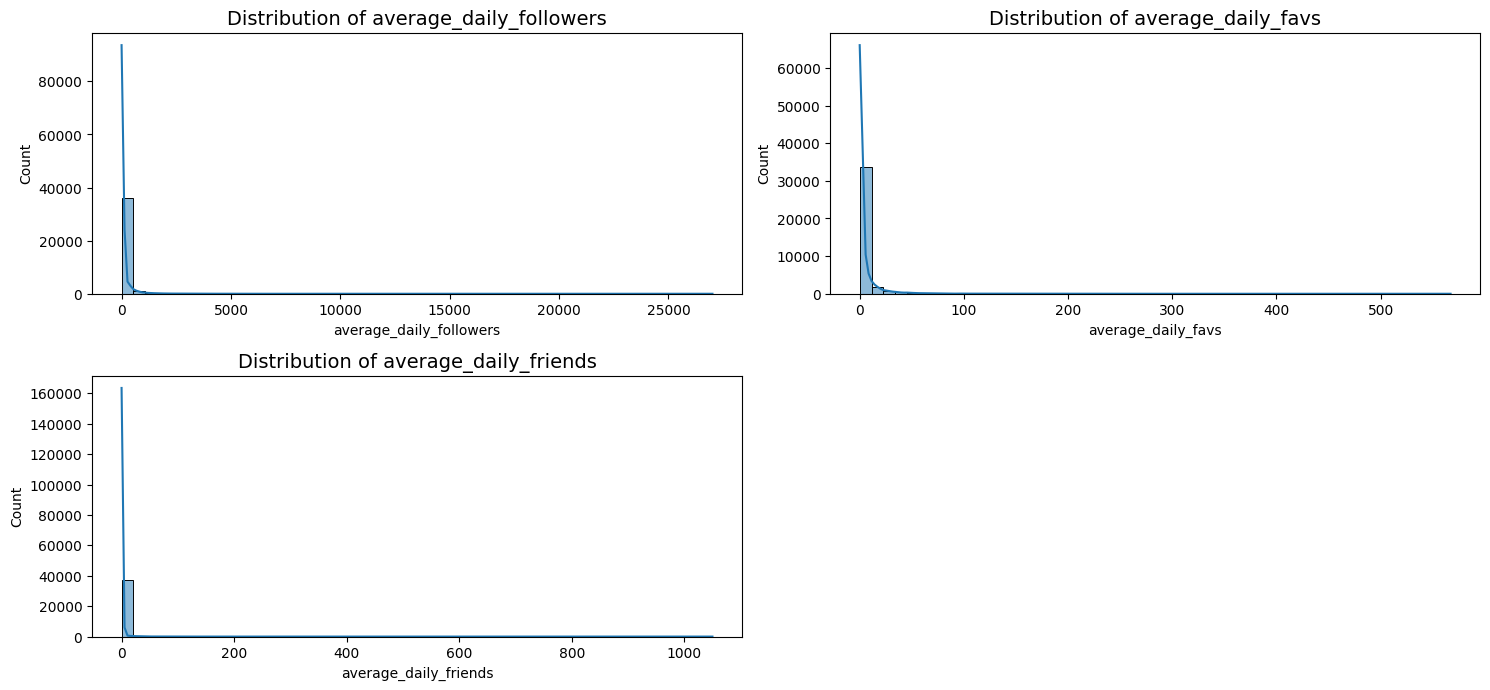

In [13]:
# List of numerical columns
numerical_columns = ['average_daily_followers', 'average_daily_favs', 'average_daily_friends']

# Plot the distribution of each numerical variable
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(dataset[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}', fontsize=14)

plt.tight_layout()
plt.show()

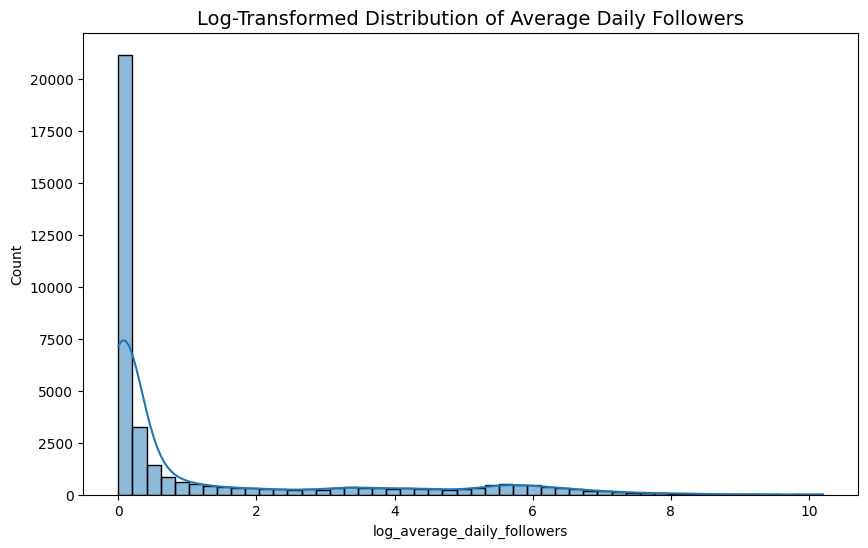

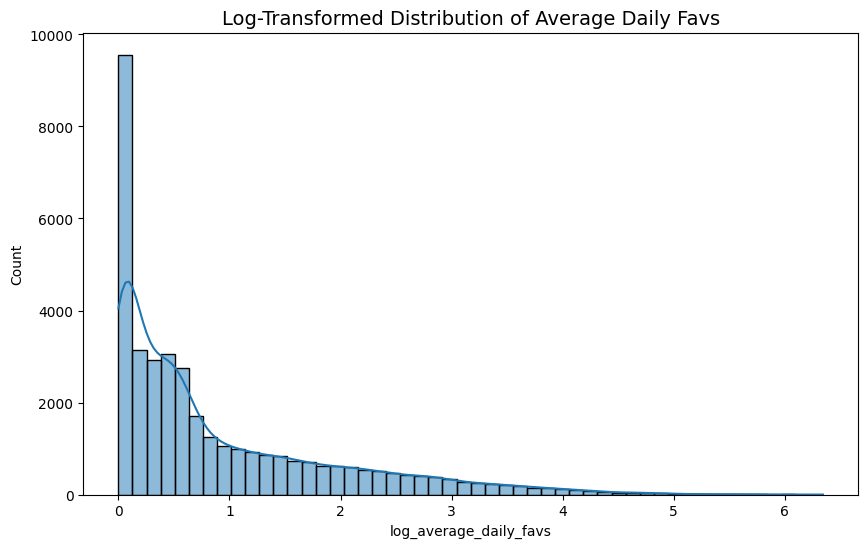

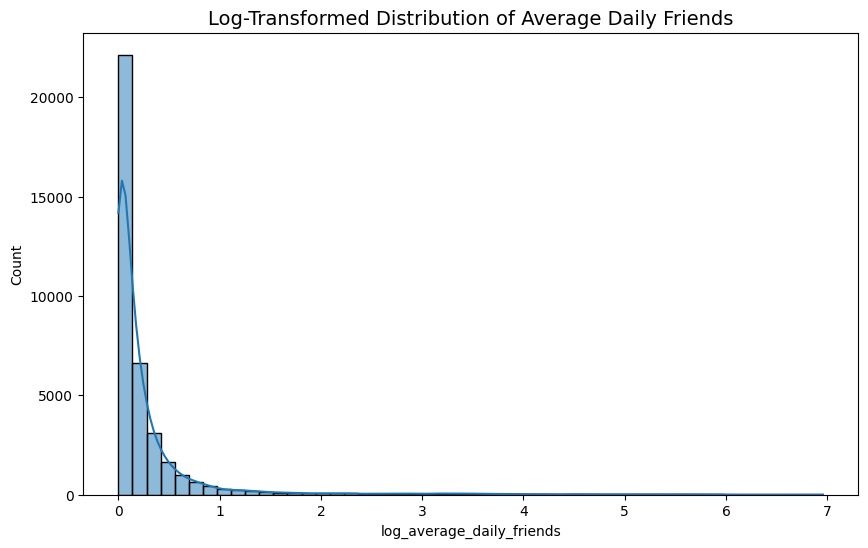

In [14]:
dataset['log_average_daily_followers'] = np.log1p(dataset['average_daily_followers'])
plt.figure(figsize=(10, 6))
sns.histplot(dataset['log_average_daily_followers'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of Average Daily Followers', fontsize=14)
plt.show()

dataset['log_average_daily_favs'] = np.log1p(dataset['average_daily_favs'])
plt.figure(figsize=(10, 6))
sns.histplot(dataset['log_average_daily_favs'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of Average Daily Favs', fontsize=14)
plt.show()

dataset['log_average_daily_friends'] = np.log1p(dataset['average_daily_friends'])
plt.figure(figsize=(10, 6))
sns.histplot(dataset['log_average_daily_friends'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of Average Daily Friends', fontsize=14)
plt.show()

# III. EDA


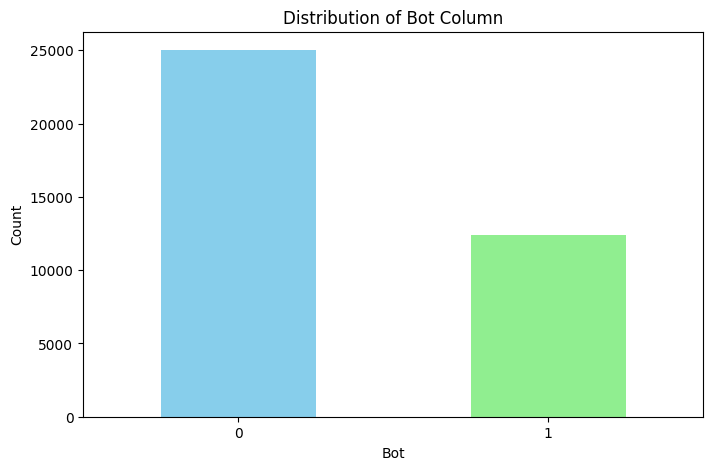

In [15]:
# Count the frequency of each value in the 'bot' column
value_counts = dataset['bot'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
value_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Distribution of Bot Column')
plt.xlabel('Bot')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

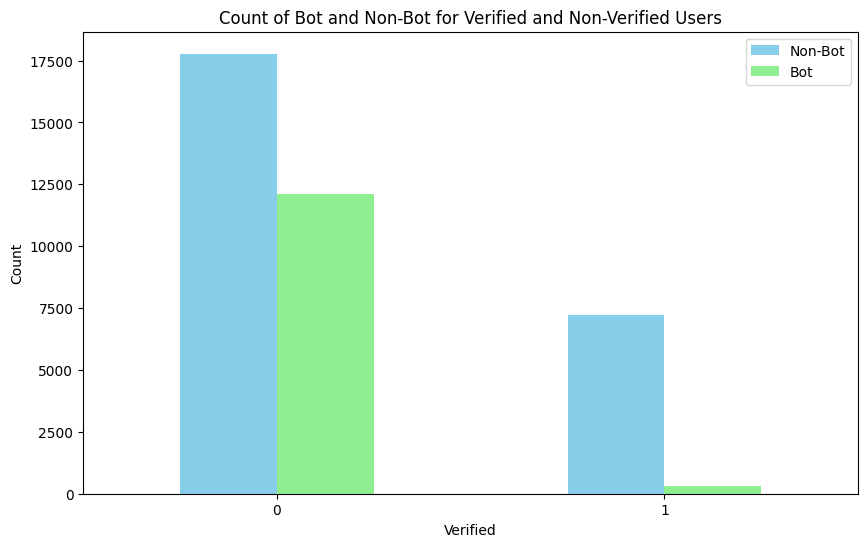

In [16]:
# Group the data by 'verified' and 'bot' columns and count the occurrences
grouped_counts = dataset.groupby(['verified', 'bot']).size().unstack()

# Plot the grouped bar chart
grouped_counts.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'])
plt.title('Count of Bot and Non-Bot for Verified and Non-Verified Users')
plt.xlabel('Verified')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(['Non-Bot', 'Bot'])
plt.show()

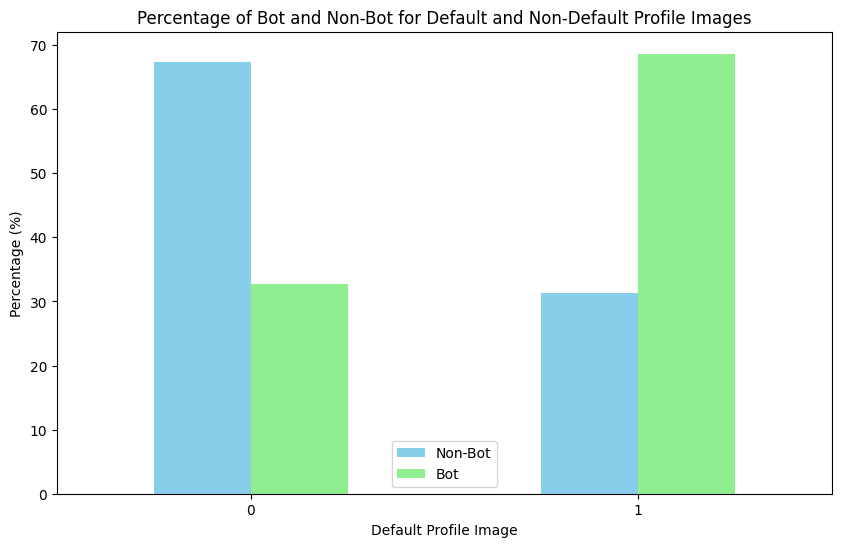

bot                            0          1
default_profile_image                      
0                      67.348156  32.651844
1                      31.362007  68.637993


In [17]:
# Group the data by 'default_profile_image' and 'bot' columns and count the occurrences
grouped_counts = dataset.groupby(['default_profile_image', 'bot']).size().unstack()

# Calculate percentages for each 'default_profile_image' group
grouped_percentages = grouped_counts.div(grouped_counts.sum(axis=1), axis=0) * 100

# Plot the grouped bar chart with percentages
grouped_percentages.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'])
plt.title('Percentage of Bot and Non-Bot for Default and Non-Default Profile Images')
plt.xlabel('Default Profile Image')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(['Non-Bot', 'Bot'])
plt.show()

print(grouped_percentages)

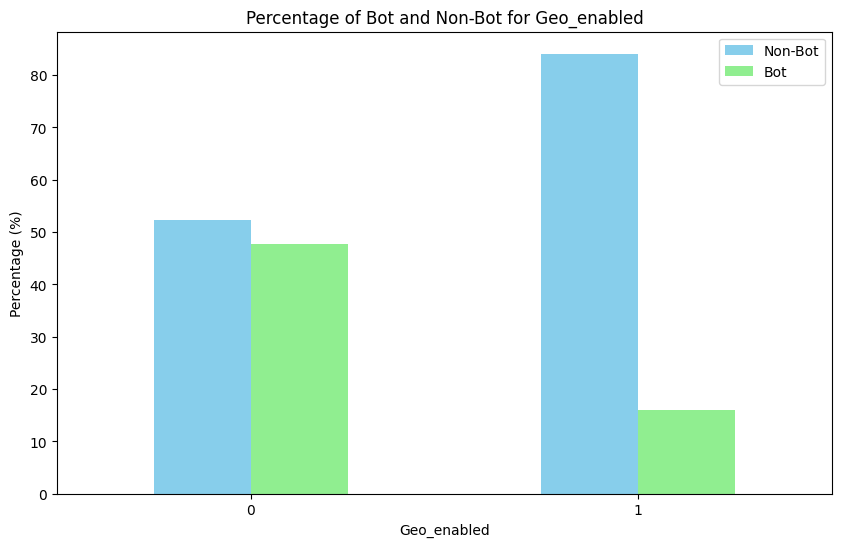

bot                  0          1
geo_enabled                      
0            52.315702  47.684298
1            84.095567  15.904433


In [18]:
# Group the data by 'geo_enabled' and 'bot' columns and count the occurrences
grouped_counts = dataset.groupby(['geo_enabled', 'bot']).size().unstack()

# Calculate percentages for each 'geo_enabled' group
grouped_percentages = grouped_counts.div(grouped_counts.sum(axis=1), axis=0) * 100

# Plot the grouped bar chart with percentages
grouped_percentages.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'])
plt.title('Percentage of Bot and Non-Bot for Geo_enabled')
plt.xlabel('Geo_enabled')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(['Non-Bot', 'Bot'])
plt.show()

print(grouped_percentages)

# IV. Correlation Analysis

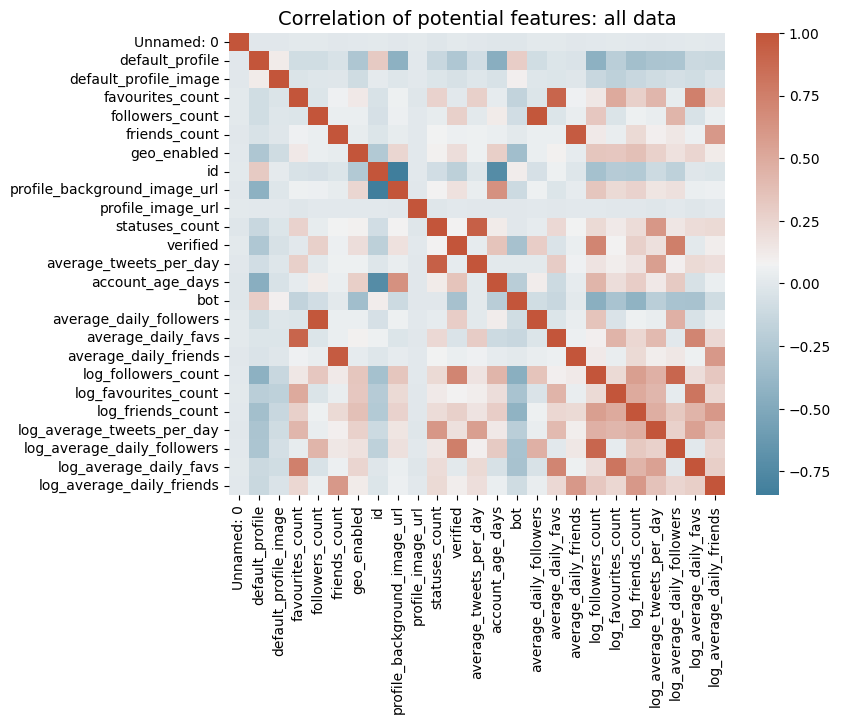

In [19]:
numerical_dataset = dataset.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(8, 6), dpi=100)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(numerical_dataset.corr(), cmap=cmap, annot=False)
plt.title('Correlation of potential features: all data', fontsize=14)
plt.show()

In [20]:
correlation_matrix = numerical_dataset.corr().abs()

# Find pairs where correlation is greater than 0.8, excluding self-correlations
high_corr_pairs = np.where((correlation_matrix > 0.8) & (correlation_matrix < 1))
high_corr_pairs = [(numerical_dataset.columns[x], numerical_dataset.columns[y]) for x, y in zip(*high_corr_pairs)]

print("Pairs of features with correlation greater than 0.8:")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {correlation_matrix.loc[pair[0], pair[1]]:.2f}")

Pairs of features with correlation greater than 0.8:
favourites_count - average_daily_favs: 0.91
followers_count - average_daily_followers: 0.99
friends_count - average_daily_friends: 0.96
id - profile_background_image_url: 0.84
profile_background_image_url - id: 0.84
statuses_count - average_tweets_per_day: 0.93
average_tweets_per_day - statuses_count: 0.93
average_daily_followers - followers_count: 0.99
average_daily_favs - favourites_count: 0.91
average_daily_friends - friends_count: 0.96
log_followers_count - log_average_daily_followers: 0.89
log_favourites_count - log_average_daily_favs: 0.81
log_average_daily_followers - log_followers_count: 0.89
log_average_daily_favs - log_favourites_count: 0.81


In [21]:
# columns_to_drop = [
#     'favourites_count',
#     'followers_count',
#     'friends_count',
#     'statuses_count',
#     'log_followers_count',
#     'log_favourites_count'
# ]
# dataset_dropped = dataset.drop(columns=columns_to_drop)
# numerical_dataset = dataset_dropped.select_dtypes(include=['float64', 'int64'])
# correlation_matrix = numerical_dataset.corr().abs()

# # Find pairs where correlation is greater than 0.8, excluding self-correlations
# high_corr_pairs = np.where((correlation_matrix > 0.8) & (correlation_matrix < 1))
# high_corr_pairs = [(numerical_dataset.columns[x], numerical_dataset.columns[y]) for x, y in zip(*high_corr_pairs)]

# print("Pairs of features with correlation greater than 0.8:")
# for pair in high_corr_pairs:
#     print(f"{pair[0]} - {pair[1]}: {correlation_matrix.loc[pair[0], pair[1]]:.2f}")

# V. Transform Text Into Embedding

Load the embeddings df

In [22]:
# Load the saved embeddings from the specified path
# loaded_embeddings_df = pd.read_pickle('/content/drive/MyDrive/BT4012/embeddings.pkl')
loaded_embeddings_df = pd.read_pickle('./embeddings.pkl')
print("Embeddings loaded successfully!")

dataset = pd.concat([dataset, loaded_embeddings_df], axis=1)

print("Embeddings concatenated with the original dataset!")

Embeddings loaded successfully!
Embeddings concatenated with the original dataset!


In [23]:
print("Columns in the dataset:")
print(dataset.columns)

Columns in the dataset:
Index(['Unnamed: 0', 'created_at', 'default_profile', 'default_profile_image',
       'description', 'favourites_count', 'followers_count', 'friends_count',
       'geo_enabled', 'id',
       ...
       'combined_emb_374', 'combined_emb_375', 'combined_emb_376',
       'combined_emb_377', 'combined_emb_378', 'combined_emb_379',
       'combined_emb_380', 'combined_emb_381', 'combined_emb_382',
       'combined_emb_383'],
      dtype='object', length=415)


This is the method to generate the embeddings (You do not need to run this if you generated the embeddings file).

In [24]:
# # Initialize the model
# model = SentenceTransformer('all-MiniLM-L6-v2')

# # Set the batch size for processing
# BATCH_SIZE = 64

# # Function to generate embeddings for a batch of text data with a progress bar
# def generate_embeddings_in_batches(texts, batch_size=BATCH_SIZE):
#     embeddings = []
#     for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):  # Add tqdm for progress bar
#         batch_texts = texts[i:i + batch_size]
#         # Encode the batch of texts
#         batch_embeddings = model.encode(batch_texts, convert_to_tensor=True)
#         embeddings.append(batch_embeddings.cpu().numpy())  # Move embeddings to CPU and convert to numpy
#     return np.vstack(embeddings)  # Stack all embeddings vertically

# # List of columns to concatenate and generate embeddings for
# text_columns = ['description', 'screen_name', 'location']

# # Concatenate text columns, handling missing values (NaN)
# dataset['combined_text'] = dataset[text_columns].fillna('').agg(' '.join, axis=1)

# # Generate embeddings for the combined text column
# print("Generating embeddings for combined text...")

# texts = dataset['combined_text'].tolist()

# # Generate embeddings for combined text with progress tracking
# embeddings = generate_embeddings_in_batches(texts, batch_size=BATCH_SIZE)

# embeddings_df = pd.DataFrame(embeddings, index=dataset.index)
# embeddings_df.columns = [f'combined_emb_{i}' for i in range(embeddings_df.shape[1])]

# dataset = pd.concat([dataset, embeddings_df], axis=1)

# print("Embeddings generation complete!")

In [25]:
# dataset_path = '/content/drive/MyDrive/BT4012/embeddings.pkl'

# embeddings_df.to_pickle(dataset_path)
# print(f"Embeddings saved to {dataset_path}")

# VI. Preparing Train-Test Split




In [26]:
features = [
    "hour_created",
    "default_profile",
    "default_profile_image",
    "geo_enabled",
    "profile_background_image_url",
    "profile_image_url",
    "verified",

    "account_age_days",

    "favourites_count",
    "followers_count",
    "friends_count",
    "statuses_count",

    "average_tweets_per_day",
    "average_daily_followers",
    "average_daily_favs",
    "average_daily_friends",

    "log_followers_count",
    "log_favourites_count",
    "log_friends_count",
    "log_average_tweets_per_day",
    "log_average_daily_followers",
    "log_average_daily_favs",
    "log_average_daily_friends"
]  + loaded_embeddings_df.columns.tolist()

In [27]:
X = dataset[features]
y = dataset['bot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# VII. Testing Individual Models

## Preparations

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
def shap_summary_with_labels_top10(shap_values, feature_names, title):
    shap_values = np.abs(shap_values.flatten())

    sorted_indices = np.argsort(-shap_values)[:10]  # Get indices of top 10 features
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_shap_values = shap_values[sorted_indices]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        y=sorted_features,
        width=sorted_shap_values,
        color='skyblue',
        edgecolor='black'
    )

    for bar, value in zip(bars, sorted_shap_values):
        plt.text(
            value,
            bar.get_y() + bar.get_height() / 2,
            f"{value:.4f}",
            va='center'
        )

    plt.xlabel("Average SHAP Value", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

In [30]:
# Define the Autoencoder model with the learning rate as a hyperparameter
def create_autoencoder(input_dim, layers=[64, 32, 16], learning_rate=0.001):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    x = input_layer
    for layer_size in layers:
        x = Dense(layer_size, activation='relu')(x)

    # Decoder
    for layer_size in reversed(layers[:-1]):
        x = Dense(layer_size, activation='relu')(x)

    output_layer = Dense(input_dim, activation='sigmoid')(x)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)

    # Compile model with dynamic learning rate
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    return autoencoder

# Create a wrapper class for Keras to work with RandomizedSearchCV
class KerasAutoencoder(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, layers=[64, 32, 16], learning_rate=0.001, epochs=50, batch_size=32):
        self.input_dim = input_dim
        self.layers = layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        return create_autoencoder(self.input_dim, layers=self.layers, learning_rate=self.learning_rate)

    def fit(self, X, y):
        self.model.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

## 7.1 Logistics Regression

In [31]:
features_log = [
    "hour_created",
    "default_profile",
    "default_profile_image",
    "geo_enabled",
    "profile_background_image_url",
    "profile_image_url",
     "verified",

    "account_age_days",

    # "favourites_count",
    # "followers_count",
    # "friends_count",
    "statuses_count",

    # "average_tweets_per_day",
    # "average_daily_followers",
    # "average_daily_favs",
    # "average_daily_friends",

    "log_followers_count",
    "log_favourites_count",
    "log_friends_count",
    "log_average_tweets_per_day",
    "log_average_daily_followers",
    "log_average_daily_favs",
    "log_average_daily_friends"
] + loaded_embeddings_df.columns.tolist()

In [32]:
X_train_log = X_train[features_log]
X_test_log = X_test[features_log]

In [39]:
log_model = LogisticRegression(random_state=42, verbose=0)

param_dist_log = {
    'C': np.logspace(-4, 1, 6),  # Regularization strength: 6 values from 1e-4 to 10
    'max_iter': [500, 1000, 2000, 3000],  # Number of iterations for convergence
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for optimization
    'fit_intercept': [True, False],  # Whether to include intercept term
    'warm_start': [True, False],  # Whether to reuse previous solution for faster fitting
}

random_search_log = RandomizedSearchCV(
    estimator=log_model,
    param_distributions=param_dist_log,
    scoring='roc_auc',
    n_iter=10,
    cv=cv,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search_log.fit(X_train_log, y_train)
best_log_reg_model = random_search_log.best_estimator_
print("\nBest Hyperparameters:")
print(random_search_log.best_params_)

/Users/yueqianh/Developer/BT4012-Dev/project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yueqianh/Developer/BT4012-Dev/project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki


Best Hyperparameters:
{'warm_start': False, 'tol': 0.0001, 'max_iter': 2000, 'fit_intercept': True, 'C': 0.1}


In [40]:
# Predict on the test set
y_pred_log = best_log_reg_model.predict(X_test_log)
y_pred_proba_log = best_log_reg_model.predict_proba(X_test_log)[:, 1]  # Probability for class 1

# Calculate and print the accuracy
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"\nAccuracy: {accuracy_log:.4f}")

# Calculate and print the AUC-ROC score
auc_roc_test_log = roc_auc_score(y_test, y_pred_proba_log)
print(f"AUC-ROC Score on Test Set: {auc_roc_test_log:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))


Accuracy: 0.8137
AUC-ROC Score on Test Set: 0.8790

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      5001
           1       0.74      0.67      0.71      2487

    accuracy                           0.81      7488
   macro avg       0.79      0.78      0.78      7488
weighted avg       0.81      0.81      0.81      7488



## 7.2 RandomForest

In [41]:
features_rf = features_log

In [42]:
X_train_rf = X_train[features_rf]
X_test_rf = X_test[features_rf]

In [43]:
rf_model = RandomForestClassifier(random_state=42, verbose=0)

param_dist_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    scoring='roc_auc',
    n_iter=10,
    cv=cv,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train_rf, y_train)

# Get the best model and hyperparameters
best_rf_model = random_search_rf.best_estimator_
print("\nBest Hyperparameters:")
print(random_search_rf.best_params_)


Best Hyperparameters:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'bootstrap': True}


In [44]:
# Predict on the test set
y_pred_rf = best_rf_model.predict(X_test_rf)
y_pred_proba_rf = best_rf_model.predict_proba(X_test_rf)[:, 1]  # Probability for class 1

# Calculate and print the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy: {accuracy_rf:.4f}")

# Calculate and print the AUC-ROC score
auc_roc_test_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC-ROC Score on Test Set: {auc_roc_test_rf:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.8653
AUC-ROC Score on Test Set: 0.9299

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5001
           1       0.81      0.78      0.79      2487

    accuracy                           0.87      7488
   macro avg       0.85      0.84      0.85      7488
weighted avg       0.86      0.87      0.86      7488



### SHAP for RandomForest

In [45]:
# Initialize the SHAP TreeExplainer
explainer_rf = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the entire test set
shap_values_rf = explainer_rf.shap_values(X_test_rf)

In [46]:
# Separate SHAP values based on the target value (0 or 1)
shap_values_0_rf = shap_values_rf[y_test == 0]
shap_values_1_rf = shap_values_rf[y_test == 1]

# Compute the average SHAP values for each group
average_shap_values_0_rf = shap_values_0_rf.mean(axis=0)
average_shap_values_1_rf = shap_values_1_rf.mean(axis=0)

# Convert averages to 2D arrays for SHAP summary plot
average_shap_values_reshaped_0_rf = np.array([average_shap_values_0_rf])
average_shap_values_reshaped_1_rf = np.array([average_shap_values_1_rf])

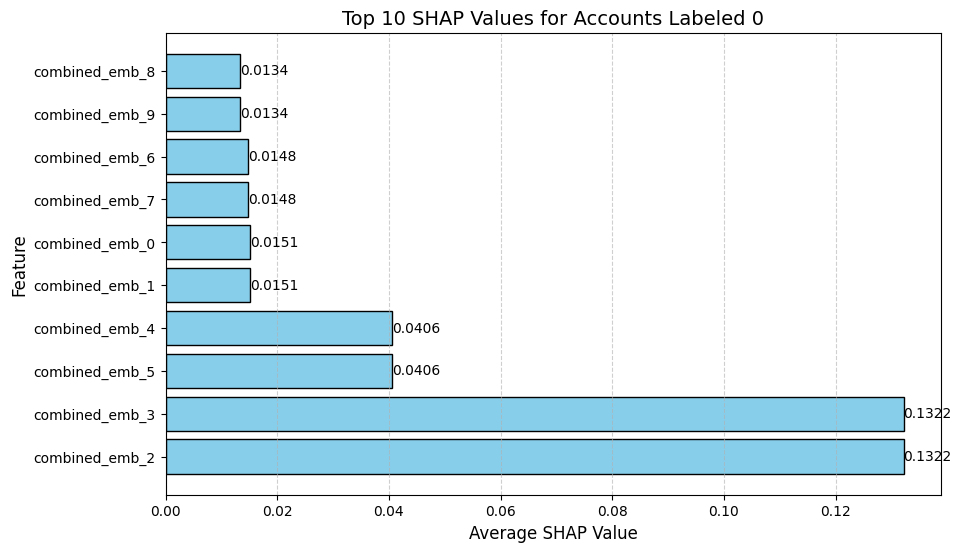

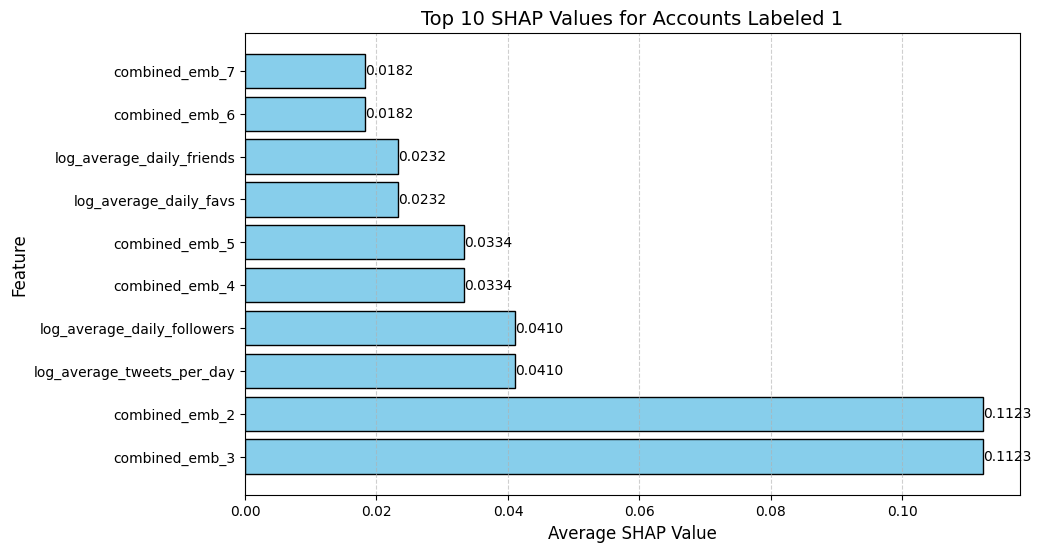

In [47]:
# Plot for accounts labeled 0
shap_summary_with_labels_top10(
    shap_values=average_shap_values_reshaped_0_rf,
    feature_names=X_test_rf.columns,
    title="Top 10 SHAP Values for Accounts Labeled 0"
)

# Plot for accounts labeled 1
shap_summary_with_labels_top10(
    shap_values=average_shap_values_reshaped_1_rf,
    feature_names=X_test_rf.columns,
    title="Top 10 SHAP Values for Accounts Labeled 1"
)

## 7.3 XGBoost

In [48]:
features_xgb = features_log

### Non-SMOTE

In [49]:
X_train_xgb = X_train[features_xgb]
X_test_xgb = X_test[features_xgb]

In [50]:
xgb_model = XGBClassifier(
    random_state=42,          # Set seed for reproducibility
    eval_metric='logloss',
)

# Define the hyperparameter grid
param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV with progress tracking for each fold
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    scoring='roc_auc',
    n_iter=10,
    n_jobs=-1,
    cv=cv,
    verbose=0,
    random_state=42,
    return_train_score=True,
)

# Fit the random search to the training data and track progress
random_search_xgb.fit(X_train_xgb, y_train)

best_model_xgb = random_search_xgb.best_estimator_
print("\nBest Hyperparameters:")
print(random_search_xgb.best_params_)


Best Hyperparameters:
{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [51]:
y_pred_xgb = best_model_xgb.predict(X_test_xgb)
y_pred_proba_xgb = best_model_xgb.predict_proba(X_test_xgb)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nAccuracy: {accuracy_xgb:.4f}")

auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"AUC-ROC Score: {auc_roc_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


Accuracy: 0.8799
AUC-ROC Score: 0.9385

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5001
           1       0.87      0.75      0.81      2487

    accuracy                           0.88      7488
   macro avg       0.88      0.85      0.86      7488
weighted avg       0.88      0.88      0.88      7488



### SMOTE

In [52]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [53]:
# Initialize the XGBoost model
xgb_model_smote = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)

# Define the hyperparameter grid
param_dist_smote = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV with progress tracking for each fold
random_search_xgb_smote = RandomizedSearchCV(
    estimator=xgb_model_smote,
    param_distributions=param_dist_smote,
    scoring='roc_auc',  # Use AUC as the scoring metric
    n_iter=10,
    n_jobs=-1,
    cv=cv,
    verbose=0,
    random_state=42,
    return_train_score=True
)

# Fit the random search to the resampled training data and track progress
random_search_xgb_smote.fit(X_train_resampled, y_train_resampled)

best_model_xgb_smote = random_search_xgb_smote.best_estimator_
print("\nBest Hyperparameters:")
print(random_search_xgb_smote.best_params_)


Best Hyperparameters:
{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [54]:
# Evaluate the model on the test set
y_pred_xgb_smote = best_model_xgb_smote.predict(X_test)
y_pred_proba_xgb_smote = best_model_xgb_smote.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_xgb_smote)
print(f"\nAccuracy: {accuracy:.4f}")

auc_roc = roc_auc_score(y_test, y_pred_proba_xgb_smote)
print(f"AUC-ROC Score: {auc_roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_smote))


Accuracy: 0.8683
AUC-ROC Score: 0.9343

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5001
           1       0.81      0.79      0.80      2487

    accuracy                           0.87      7488
   macro avg       0.85      0.85      0.85      7488
weighted avg       0.87      0.87      0.87      7488



### SHAP for XGBoost

In [55]:
# Initialize the SHAP TreeExplainer
explainer_xgb = shap.TreeExplainer(best_model_xgb)

# Calculate SHAP values for the entire test set
shap_values_xgb = explainer_xgb.shap_values(X_test_xgb)

In [56]:
# Separate SHAP values based on the target value (0 or 1)
shap_values_0_xgb = shap_values_xgb[y_test == 0]
shap_values_1_xgb = shap_values_xgb[y_test == 1]

# Compute the average SHAP values for each group
average_shap_values_0_xgb = shap_values_0_xgb.mean(axis=0)
average_shap_values_1_xgb = shap_values_1_xgb.mean(axis=0)

# Convert averages to 2D arrays for SHAP summary plot
average_shap_values_reshaped_0_xgb = np.array([average_shap_values_0_xgb])
average_shap_values_reshaped_1_xgb = np.array([average_shap_values_1_xgb])

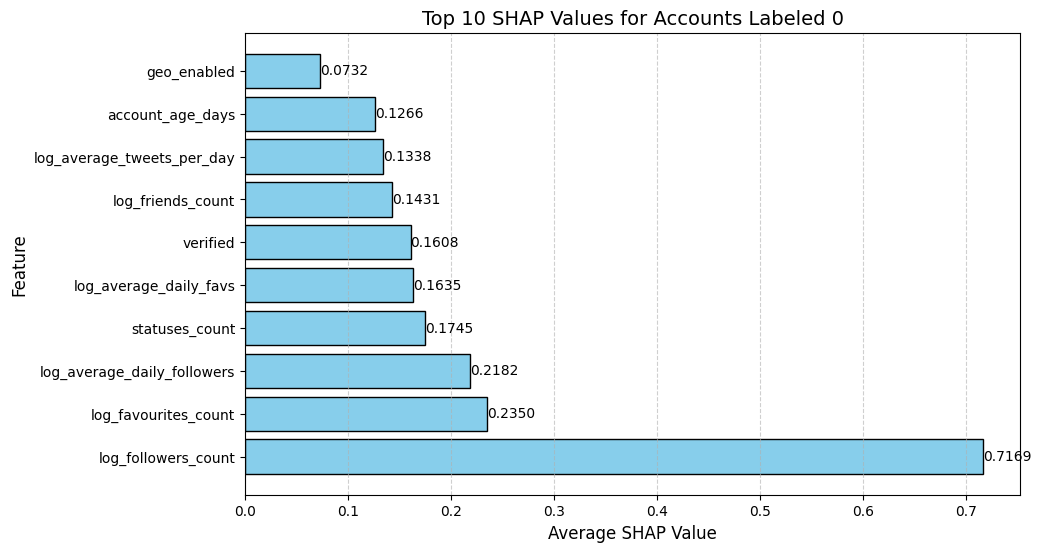

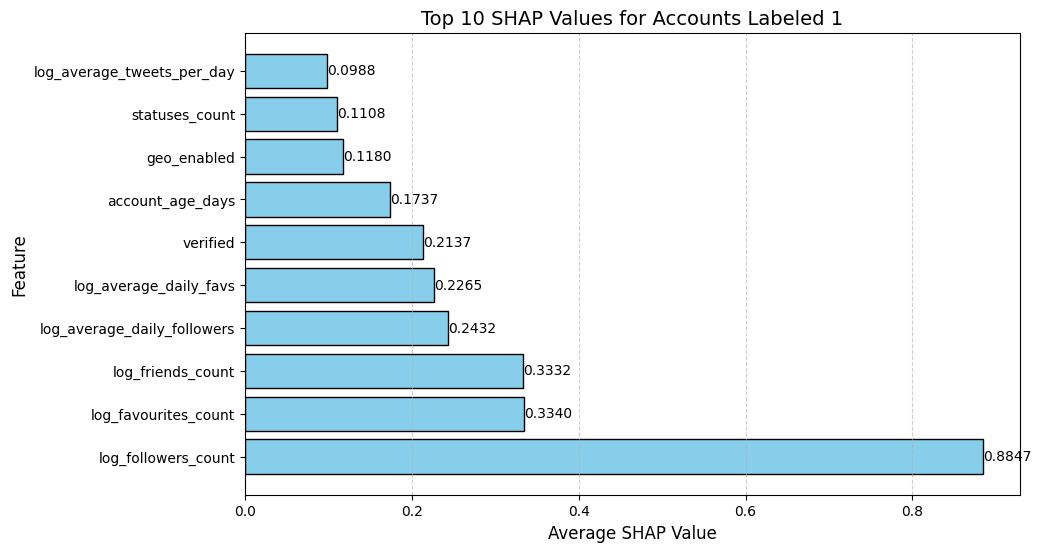

In [57]:
# Plot for accounts labeled 0
shap_summary_with_labels_top10(
    shap_values=average_shap_values_reshaped_0_xgb,
    feature_names=X_test_xgb.columns,
    title="Top 10 SHAP Values for Accounts Labeled 0"
)

# Plot for accounts labeled 1
shap_summary_with_labels_top10(
    shap_values=average_shap_values_reshaped_1_xgb,
    feature_names=X_test_xgb.columns,
    title="Top 10 SHAP Values for Accounts Labeled 1"
)

## 7.4 K-Nearest Neighbours

In [58]:
features_knn = features_log

In [59]:
X_train_knn = X_train[features_knn]
X_test_knn = X_test[features_knn]

In [60]:
knn_model = KNeighborsClassifier()

# Define the hyperparameter grid
param_dist_knn = {
    'n_neighbors': np.arange(1, 31),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1 for Manhattan, 2 for Euclidean)
    'metric': ['minkowski']  # Distance metric
}

random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    scoring='roc_auc',
    n_iter=10,
    cv=cv,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search_knn.fit(X_train_knn, y_train)

# Get the best model and hyperparameters
best_knn_model = random_search_knn.best_estimator_
print("\nBest Hyperparameters:")
print(random_search_knn.best_params_)


Best Hyperparameters:
{'weights': 'distance', 'p': 1, 'n_neighbors': 19, 'metric': 'minkowski'}


In [61]:
# Predict on the test set
y_pred_knn = best_knn_model.predict(X_test_knn)
y_pred_proba_knn = best_knn_model.predict_proba(X_test_knn)[:, 1]  # Probability for class 1

# Calculate and print the accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\nAccuracy: {accuracy:.4f}")

# Calculate and print the AUC-ROC score
auc_roc_test_knn = roc_auc_score(y_test, y_pred_proba_knn)
print(f"AUC-ROC Score on Test Set: {auc_roc_test_knn:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))


Accuracy: 0.8683
AUC-ROC Score on Test Set: 0.7948

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      5001
           1       0.68      0.52      0.59      2487

    accuracy                           0.76      7488
   macro avg       0.73      0.70      0.71      7488
weighted avg       0.75      0.76      0.75      7488



## 7.5 Autoencoder

In [62]:
features_auto = features_log

In [63]:
X_train_auto = X_train[features_auto]
X_test_auto = X_test[features_auto]

In [66]:
# Normalize the data
X_train_auto = X_train_auto / np.max(X_train)
X_test_auto = X_test_auto / np.max(X_test)

# Define the autoencoder
input_dim = X_train_auto.shape[1]
encoding_dim = 10  # Size of the latent representation

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train the autoencoder
autoencoder.fit(X_train_auto, X_train_auto, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Extract the encoder part of the autoencoder
encoder = Model(inputs=input_layer, outputs=encoded)

# Encode the data to obtain the latent representation
X_train_encoded = encoder.predict(X_train_auto)
X_test_encoded = encoder.predict(X_test_auto)

# Define a simple classifier using the latent representation
classifier = Sequential()
classifier.add(Dense(10, activation="relu", input_dim=encoding_dim))
classifier.add(Dense(1, activation="sigmoid"))

# Compile the classifier
classifier.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the classifier
classifier.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the classifier
y_pred_auto = classifier.predict(X_test_encoded)
y_pred_class_auto = (y_pred_auto > 0.5).astype(int)

# Print classification report
print("Accuracy:", accuracy_score(y_test, y_pred_class_auto))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class_auto))
auc_roc = roc_auc_score(y_test, y_pred_auto)
print(f"AUC-ROC Score: {auc_roc:.4f}")

Epoch 1/50


2024-11-22 10:39:14.748841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1525 - val_loss: 0.0055
Epoch 2/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0035 - val_loss: 9.8248e-04
Epoch 3/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.6604e-04 - val_loss: 3.6685e-04
Epoch 4/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.0589e-04 - val_loss: 1.7635e-04
Epoch 5/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.5182e-04 - val_loss: 9.5818e-05
Epoch 6/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8.3978e-05 - val_loss: 5.5796e-05
Epoch 7/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 4.9441e-05 - val_loss: 3.3914e-05
Epoch 8/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.0267e-05 - val_loss: 2.1204e-05
Epoch 9/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.9017e-05 - val_loss: 1.3519e-05
Epoch 10/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.2168e-05 - val_loss: 8.7442e-06
Epoch 11/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.8920e-06 - val_loss

## 7.6 Support Vector Machine (SVM)

In [32]:
# Based on the correlation analysis above, "statuses_count" and "log_average_daily_friends" are removed.

features_svm = [
    "hour_created",
    "default_profile",
    "default_profile_image",
    "geo_enabled",
    "profile_background_image_url",
    "profile_image_url",
    "verified",

    "account_age_days",

    # "favourites_count",
    # "followers_count",
    # "friends_count",
    # "statuses_count",

    # "average_tweets_per_day",
    # "average_daily_followers",
    # "average_daily_favs",
    # "average_daily_friends",

    "log_followers_count",
    "log_favourites_count",
    "log_friends_count",
    "log_average_tweets_per_day",
    "log_average_daily_followers",
    "log_average_daily_favs",
    # "log_average_daily_friends"
]

In [33]:
X_train_svm = X_train[features_svm]
X_test_svm = X_test[features_svm]

In [34]:
svm_model = SVC(kernel='linear', probability=True)

svm_model.fit(X_train_svm, y_train)

SVC(kernel='linear', probability=True)

In [35]:
y_pred_svm = svm_model.predict(X_test_svm)
y_pred_proba_svm = svm_model.predict_proba(X_test_svm)[:, 1]

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm:.4f}")

auc_roc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"AUC-ROC Score: {auc_roc_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.8066
AUC-ROC Score: 0.8603

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      5001
           1       0.74      0.64      0.69      2487

    accuracy                           0.81      7488
   macro avg       0.79      0.77      0.77      7488
weighted avg       0.80      0.81      0.80      7488



# VIII. Ensemble Methods

## 8.1 Stacking Classifier

In [36]:
features_stack = features_log

In [37]:
X_train_stack = X_train[features_stack]
X_test_stack = X_test[features_stack]

In [38]:
# Meta-classifier
meta_clf = LogisticRegression()

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('log', LogisticRegression(random_state=42, max_iter=2000, C=0.1, warm_start=False, tol=0.0001, fit_intercept=True)),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_features=None, max_depth=10, criterion='log_loss', class_weight='balanced_subsample', bootstrap=True)),
        ('xgb', XGBClassifier(random_state=42, subsample=1.0, n_estimators=100, max_depth=10, learning_rate=0.1, colsample_bytree=1.0)),
        ('knn', KNeighborsClassifier(weights='distance', p=1, n_neighbors=19, metric='minkowski'))
    ],
    final_estimator=meta_clf,
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Fit the stacking model
stacking_clf.fit(X_train_stack, y_train)

/Users/yueqianh/Developer/BT4012-Dev/project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yueqianh/Developer/BT4012-Dev/project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

StackingClassifier(cv=5,
                   estimators=[('log',
                                LogisticRegression(C=0.1, max_iter=2000,
                                                   random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='log_loss',
                                                       max_depth=10,
                                                       max_features=None,
                                                       min_samples_leaf=4,
                                                       n_estimators=500,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_byleve...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=19, p=1,
                                                     weights='distance'))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [39]:
# Predictions
y_pred_stack = stacking_clf.predict(X_test_stack)
y_pred_proba_stack = stacking_clf.predict_proba(X_test_stack)[:, 1]

# Evaluate the model
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print(f"Accuracy: {accuracy_stack:.4f}")

auc_roc_stack = roc_auc_score(y_test, y_pred_proba_stack)
print(f"AUC-ROC Score: {auc_roc_stack:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack))

Accuracy: 0.8770
AUC-ROC Score: 0.9351

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5001
           1       0.86      0.76      0.80      2487

    accuracy                           0.88      7488
   macro avg       0.87      0.85      0.86      7488
weighted avg       0.88      0.88      0.87      7488



## 8.2 Voting Classifier

In [40]:
features_vote = features_log

In [41]:
X_train_vote = X_train[features_vote]
X_test_vote = X_test[features_vote]

In [42]:
voting_clf = VotingClassifier(
    estimators=[
        ('log', LogisticRegression(random_state=42, max_iter=2000, C=0.1, warm_start=False, tol=0.0001, fit_intercept=True)),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_features=None, max_depth=10, criterion='log_loss', class_weight='balanced_subsample', bootstrap=True)),
        ('xgb', XGBClassifier(random_state=42, subsample=1.0, n_estimators=100, max_depth=10, learning_rate=0.1, colsample_bytree=1.0)),
        ('knn', KNeighborsClassifier(weights='distance', p=1, n_neighbors=19, metric='minkowski'))
    ],
    voting='soft',
    n_jobs=-1,
    verbose=0
)

# Fit the voting classifier
voting_clf.fit(X_train_vote, y_train)

/Users/yueqianh/Developer/BT4012-Dev/project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('log',
                              LogisticRegression(C=0.1, max_iter=2000,
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='log_loss',
                                                     max_depth=10,
                                                     max_features=None,
                                                     min_samples_leaf=4,
                                                     n_estimators=500,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=19, p=1,
                                                   weights='distance'))],
                 n_jobs=-1, verbose=0, voting='soft')

In [43]:
y_pred_vote = voting_clf.predict(X_test_vote)
y_pred_proba_vote = voting_clf.predict_proba(X_test_vote)[:, 1]

accuracy_vote = accuracy_score(y_test, y_pred_vote)
print(f"Accuracy: {accuracy_vote:.4f}")

auc_roc_vote = roc_auc_score(y_test, y_pred_proba_vote)
print(f"AUC-ROC Score: {auc_roc_vote:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_vote))

Accuracy: 0.8745
AUC-ROC Score: 0.9258

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5001
           1       0.87      0.73      0.79      2487

    accuracy                           0.87      7488
   macro avg       0.87      0.84      0.85      7488
weighted avg       0.87      0.87      0.87      7488

